In [1219]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1220]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [1221]:
X, y, Xval, yval, Xtest, ytest = load_data()

E:\develop\anaconda\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
E:\develop\anaconda\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


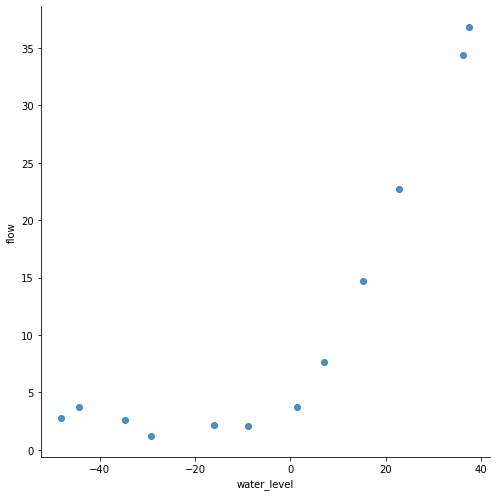

In [1222]:
df = pd.DataFrame({'water_level': X, 'flow': y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [1223]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

---

代价函数

In [1224]:
def cost(theta, X, y):
    m = X.shape[0]

    inner = X @ theta - y
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [1225]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

---

梯度

In [1226]:
def gradient(theta, X, y):
    m = X.shape[0]
    grad = (X.T @ (X @ theta - y)) / m
    return grad

In [1227]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

---

正则化

In [1228]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    regularized_term = theta.copy()
    regularized_term[0] = 0
    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [1229]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

In [1230]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (1 / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

---

拟合数据

In [1231]:
def linear_regression_np(X, y, l=1):
    # STEP1：初始化参数
    theta = np.ones(X.shape[1])

    # STEP2：调用优化算法拟合参数
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [1232]:
#theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

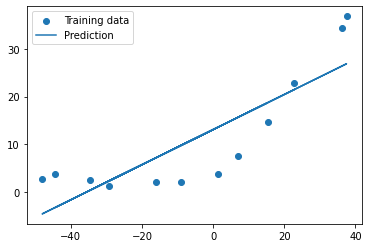

In [1233]:
b = final_theta[0]
m = final_theta[1]

plt.scatter(X[:, 1], y, label='Training data')
plt.plot(X[:, 1], X[:, 1] * m + b, label='Prediction')
plt.legend(loc=2)
plt.show()

In [1234]:
training_cost, cv_cost = [], []

In [1235]:
m = X.shape[0]

for i in range(1, m + 1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)

    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = cost(res.x, Xval, yval)

    training_cost.append(tc)
    cv_cost.append(cv)

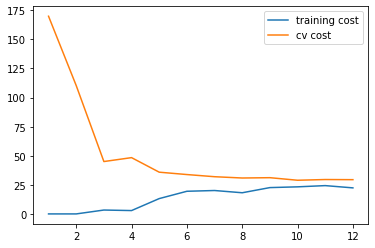

In [1236]:
plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

---

创建多项式特征

In [1237]:
def prepare_poly_data(*args, power):
    def prepare(x):
        df = poly_features(x, power=power)

        ndarr = normalize_feature(df).values
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [1238]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [1239]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [1240]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


---

准备多项式回归数据

In [1241]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [1242]:
X, y, Xval, yval, Xtest, ytest = load_data()
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

---

画出学习曲线

In [1243]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    # STEP1：初始化参数，获取样本个数，开始遍历
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # STEP2：调用之前写好的拟合数据函数进行数据拟合
        res = linear_regression_np(X[:i, :], y[:i], l)  # 注意这里是l，那么就可以根据函数给的l值进行限制

        # STEP3：计算样本代价
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        # STEP3：把计算结果存储至预先定义的数组training_cost, cv_cost中
        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

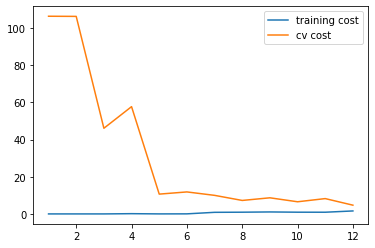

In [1244]:
theta = np.ones(9)
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

---

try lamda =1

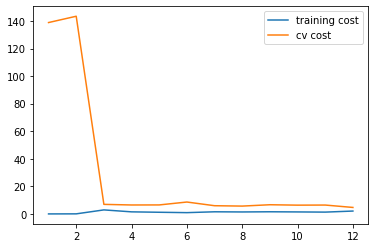

In [1245]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

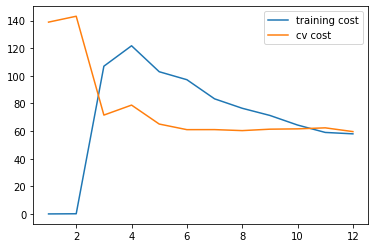

In [1246]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

---

找到最佳的lamda

In [1247]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [1248]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)

    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)

    training_cost.append(tc)
    cv_cost.append(cv)

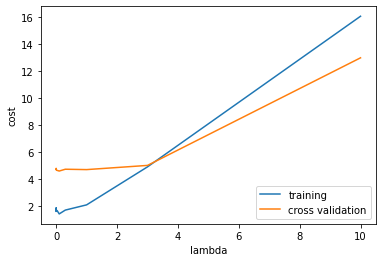

In [1249]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=4)

plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

In [1250]:
l_candidate[np.argmin(cv_cost)]

0.1

In [1251]:
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 6.138850385431229
test cost(l=0.001) = 6.0994403224140115
test cost(l=0.003) = 6.130664132638152
test cost(l=0.01) = 6.116078999931956
test cost(l=0.03) = 6.068408660342925
test cost(l=0.1) = 6.398893136407939
test cost(l=0.3) = 6.582261325050876
test cost(l=1) = 7.466281412019082
test cost(l=3) = 11.645566107831261
test cost(l=10) = 27.715071112015135
